# Physics-informed neural networks (PINNs): an introductory crash-course

By Ben Moseley, 2022

This workshop builds upon my blog post on PINNs: https://benmoseley.blog/my-research/so-what-is-a-physics-informed-neural-network/. 

Read the seminal PINN papers [here](https://ieeexplore.ieee.org/document/712178) and [here](https://www.sciencedirect.com/science/article/pii/S0021999118307125).


## Workshop goals

By the end of this workshop, you should be able to:
- code a PINN from scratch in PyTorch
- understand the different types of scientific tasks PINNs can be used for
- understand in more detail how PINNs are trained and how to improve their convergence


## Task overview

We will be coding a PINN from scratch in PyTorch and using it solve simulation and inversion tasks related to the damped harmonic oscillator.


## Environment set up

First, use the code below to set up your python / Jupyter notebook environment. Using conda is not essential; the required python libraries are listed below.

```bash
conda create -n workshop python=3
conda activate workshop
conda install jupyter numpy matplotlib
conda install pytorch torchvision torchaudio -c pytorch
```

In [1]:
import torch
import torch.nn as nn
from torchsummary import summary # https://pypi.org/project/torch-summary/
import torchinfo 
import numpy as np
import matplotlib.pyplot as plt


## Problem overview

We are going to use a PINN to solve problems related to the **damped harmonic oscillator**:

<img src="oscillator.gif" width="500">

We are interested in modelling the displacement of the mass on a spring (green box) over time.

This is a canonical physics problem, where the displacement, $u(t)$, of the oscillator as a function of time can be described by the following differential equation:

$$
m \dfrac{d^2 u}{d t^2} + \mu \dfrac{d u}{d t} + ku = 0~,
$$

where $m$ is the mass of the oscillator, $\mu$ is the coefficient of friction and $k$ is the spring constant.

We will focus on solving the problem in the **under-damped state**, i.e. where the oscillation is slowly damped by friction (as displayed in the animation above). 

Mathematically, this occurs when:

$$
\delta < \omega_0~,~~~~~\mathrm{where}~~\delta = \dfrac{\mu}{2m}~,~\omega_0 = \sqrt{\dfrac{k}{m}}~.
$$

Furthermore, we consider the following initial conditions of the system:

$$
u(t=0) = 1~~,~~\dfrac{d u}{d t}(t=0) = 0~.
$$

For this particular case, the exact solution is known and given by:

$$
u(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))~,~~~~~\mathrm{with}~~\omega=\sqrt{\omega_0^2 - \delta^2}~.
$$



For a more detailed mathematical description of the harmonic oscillator, check out this blog post: https://beltoforion.de/en/harmonic_oscillator/.

## Workflow overview

There are **two scientific tasks** related to the harmonic oscillator we will use a PINN for:

>First, we will **simulate** the system using a PINN, given its initial conditions.

>Second, we will **invert** for underlying parameters of the system using a PINN, given some noisy observations of the oscillator's displacement.

>Finally, we will investigate how well the PINN **scales** to higher frequency oscillations and what can be done to improve its convergence.

## Task 1: train a PINN to simulate the system

#### Task

The first task is to use a PINN to **simulate** the system.

Specifically, our inputs and outputs are:

- Inputs: underlying differential equation and the initial conditions of the system
- Outputs: estimate of the solution, $u(t)$

#### Approach

The PINN is trained to directly approximate the solution to the differential equation, i.e.

$$
u_{\mathrm{PINN}}(t;\theta) \approx u(t)~,
$$

where $\theta$ are the free parameters of the PINN.

#### Loss function

To simulate the system, the PINN is trained with the following loss function:

$$
\mathcal{L}(\theta)= (u_{\mathrm{PINN}}(t=0;\theta) - 1)^2 + \lambda_1 \left(\frac{d\,u_{\mathrm{PINN}}}{dt}(t=0;\theta) - 0\right)^2 + \frac{\lambda_2}{N} \sum^{N}_{i} \left( \left[ m\frac{d^2}{dt^2} + \mu \frac{d}{dt} + k \right] u_{\mathrm{PINN}}(t_{i};\theta)  \right)^2
$$

For this task, we use $\delta=2$, $\omega_0=20$, and try to learn the solution over the domain $t\in [0,1]$.

#### Notes

The first two terms in the loss function represent the **boundary loss**, and tries to ensure that the solution learned by the PINN matches the initial conditions of the system, namely, $u(t=0)=1$ and $u'(t=0)=0$.

The second term in the loss function is called the **physics loss**, and and tries to ensure that the PINN solution obeys the underlying differential equation at a set of training points $\{t_i\}$ sampled over the entire domain.

The hyperparameters, $\lambda_1$ and $\lambda_2$, are used to balence the terms in the loss function, to ensure stability during training.

Autodifferentiation (`torch.autograd`) is used to calculate the gradients of the PINN with respect to its input required to evaluate the loss function. This is very powerful! 

For more details on `torch.autograd`, check out [this](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#a-gentle-introduction-to-torch-autograd) tutorial.

### Norms


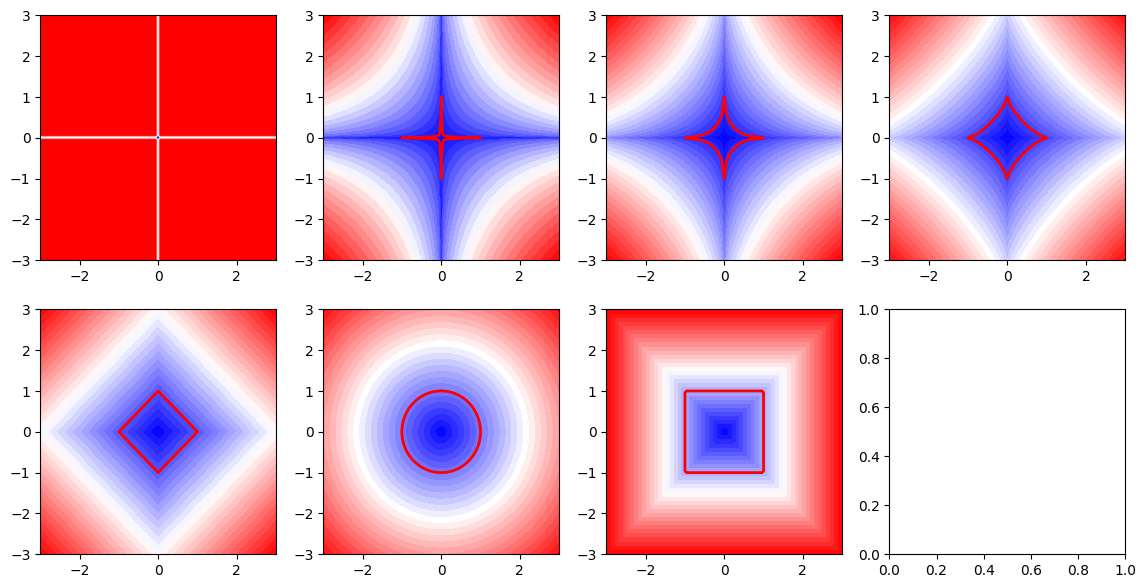

In [2]:
# L-norms
# Ref: https://stackoverflow.com/questions/48723466/l0-and-inf-norms-plotting-with-contour-contourf 
import matplotlib.pyplot as plt
import numpy as np

p_values = [0., 0.25, 0.5, 0.75, 1, 2, 8, np.inf]
xx, yy = np.meshgrid(np.linspace(-3, 3, num=101), np.linspace(-3, 3, num=101))
fig, axes = plt.subplots(ncols=(len(p_values) + 1)// 2,
                     nrows=2, figsize=(14, 7))
for p, ax in zip(p_values, axes.flat):
    if p == 0:
        zz = (xx != 0).astype(int) + (yy != 0).astype(int)
        ax.imshow(zz, cmap='bwr', extent=(xx.min(),xx.max(),yy.min(),yy.max()), aspect="auto")
    else:
        if np.isinf(p):
            zz = np.maximum(np.abs(xx),np.abs(yy))
        else:
            zz = ((np.abs((xx))**p) + (np.abs((yy))**p))**(1./p)
        ax.contourf(xx, yy, zz, 30, cmap='bwr')
        ax.contour(xx,yy,zz, [1], colors='red', linewidths = 2) 

plt.show()

### Step 1: Definition and initialization

In [235]:
import torch
import torch.nn as nn
from torchsummary import summary # https://pypi.org/project/torch-summary/
import torchinfo 
import numpy as np
import matplotlib.pyplot as plt

#### CUDA

In [236]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [237]:
torch.cuda.current_device()

0

In [238]:
if torch.cuda.is_available():
    my_device = torch.device('cuda')
else:
    my_device = torch.device('cpu')
print('Device: {}'.format(my_device))

Device: cuda


In [239]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

#### Definitions 

In [240]:
torch.manual_seed(123)
# https://pytorch.org/docs/stable/generated/torch.manual_seed.html
# https://discuss.pytorch.org/t/what-is-manual-seed/5939/13
# https://en.wikipedia.org/wiki/Pseudorandom_number_generator
# https://pytorch.org/docs/stable/notes/randomness.html

In [241]:
# -----------------------------------------------------------------------------DEFINITIONS--------------------------------------------

# --------------------------------------------------------------------------Physical constants:
mass = 1 #(not used in the equation)
delta = 2 # delta = frict_coeff/(2*mass)
#mu = 2*delta
w0 = 20 # square root(spring constant/mass)
spring_constant = w0**2
# Cases:
#    delta > w0: overdamped (strong friction)
#    delta == w0: critically damped (transition from overdamped to oscillation)
#    delta < w0: damped oscillation ***OUR CASE***
 
# Training points:
physics_t_initial = 0
physics_t_end = 1 
physics_t_points = 20

# Coefficient of friction:
frict_coeff_min = 1
frict_coeff_max = 5
frict_coeff_points = 4

# Initial points: 
initial_t = 0.
initial_frict_coeff = 1.

# Test points:
test_t_initial = 0
test_t_final = 1
test_t_points = 300
test_frict_coeff_evaluate = 5

# ---------------------------------------------------------------------------------Hyperparameters
# epochs:
epochs = 15001
# Learning Rate:
learning_rate = 1e-3
# compute each term of the PINN loss function above using the following hyperparameters:
hyperparam_loss_initial = 1e-1
hyperparam_loss_physics = 1e-4


In [242]:
# Define training points over the entire domain, for the physics loss
physics_t = torch.linspace(start = physics_t_initial, end = physics_t_end, steps = physics_t_points).view(-1,1).requires_grad_(True).to(device)
physics_t
physics_t_total = physics_t.repeat(frict_coeff_points,1)
#physics_t_total
#physics_t_total

In [243]:
# Define coefficient of friction points as input parameter together with the temporal variable over the entire domain, for the physics loss
frict_coeff = torch.linspace(start = frict_coeff_min, end = frict_coeff_max, steps = frict_coeff_points).view(-1, 1).requires_grad_(True).to(device)
frict_coeff
frict_coeff_total = torch.reshape(frict_coeff.repeat(1, physics_t_points), (-1, 1))
frict_coeff_total.numel()
physics_t_frict_coeff = torch.cat((physics_t_total, frict_coeff_total), dim = 1)
#physics_t_frict_coeff.numel()
#frict_coeff
#frict_coeff_total.numel()
#physics_t_frict_coeff

In [244]:
# Define initial points for the loss
initial_t_frict_coeff = torch.tensor([initial_t, initial_frict_coeff]).view(1,-1).requires_grad_(True).to(device)
#initial_t_frict_coeff
#initial_t_frict_coeff.size()
#initial_t_frict_coeff.numel()
#initial_t_frict_coeff.dim()

In [245]:
# Define temporal points for the test
test_t = torch.linspace(test_t_initial, test_t_final, test_t_points).view(-1,1).to(device)
    # ?? No sé necesita requires_grad_(True) pq no se necesita guardar operaciones en el tensor de test
    # si no sólo los tensores de training 
#test_t
#test_t.numel()
#test_t.size()
#test_t.dim()

In [246]:
test_frict_coeff = (torch.ones_like(test_t)*test_frict_coeff_evaluate).to(device)
test_t_frict_coeff_total = torch.cat((test_t, test_frict_coeff), dim = 1)
#test_t_frict_coeff_total
print(f"Device tensor is stored on: {test_t_frict_coeff_total.device}")

Device tensor is stored on: cuda:0


#### Exact solution:

In [247]:
def exact_solution_np(delta, w0, t):
    """
    Defines the analytical solution to the under-damped harmonic oscillator problem above."
    ---
    Inputs:
        delta (constant): frict_coeff/(2*mass)
        w0(constant): square root(spring constant/mass)
        t(tensor): temporal point
    Outputs:
        u(tensor): displacements along the time
    """
    #assert delta < w0             # delta < w0: damped oscillation. expected d < w: https://realpython.com/python-assert-statement/    
    w = np.sqrt(w0**2-delta**2)
    phi = np.arctan(-delta/w)
    A = 1/(2*np.cos(phi))     # as torch.cos needs a tensor as input, used np
    cos = torch.cos(phi+w*t)
    exp = torch.exp(-delta*t)
    u = exp*(2*A*cos)
    return u

In [248]:
def exact_solution(delta, w0, t):
    """
    Defines the analytical solution to the under-damped harmonic oscillator problem above."
    ---
    Inputs:
        delta (constant): frict_coeff/(2*mass)
        w0(constant): square root(spring constant/mass)
        t(tensor): temporal point
    Outputs:
        u(tensor): displacements along the time
    """
    #assert delta < w0             # delta < w0: damped oscillation. expected d < w: https://realpython.com/python-assert-statement/    
    #print(delta)
    w = torch.sqrt(w0**2-delta**2)
    phi = torch.arctan(-delta/w)
    A = 1/(2*torch.cos(phi))     # as torch.cos needs a tensor as input, used np
    cos = torch.cos(phi+w*t)
    exp = torch.exp(-delta*t)
    u = exp*(2*A*cos)
    return u

In [249]:
# Calculation of the exact solution:
u_exact = exact_solution(test_t_frict_coeff_total[:,1]/(2*mass), w0, test_t_frict_coeff_total[:,0])
#u_exact.view(-1,1)
u_exact.size()
#u_exact.numel()
#u_exact.dim()
#u_exact

torch.Size([300])

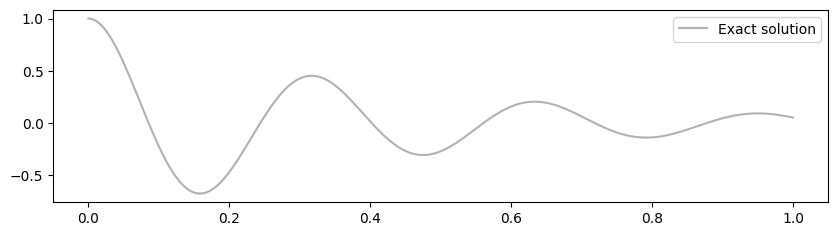

In [250]:
plt.figure(figsize=(10,2.5))
plt.plot(test_t_frict_coeff_total.cpu()[:,0], 
         u_exact.cpu(), 
         label="Exact solution", 
         color="tab:grey", 
         alpha=0.6)
plt.legend()
plt.show()


### Step 2: Create Model Class (NN)

In [251]:
class FCN(nn.Module):   # inherent from nn.Module
    "Defines a standard fully-connected network in PyTorch"
    # Initialization of the neural network layers in __init__:
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()                                      
        
        # INPUT Linear function: 1x1 --> 32x1: [A](32x1)*[X](1x1) + [b](32x1)
        self.fc_in = nn.Linear(input_dim, hidden_dim)
        
        # INPUT Non-linearity (activation function): 32x1-->32x1
        self.tangh = nn.Tanh()
        
        # OUTPUT Linear function: 32x1 --> 1x1: [A](32x1)*[X](1x1) + [b](32x1)
        self.fc_out = nn.Linear(hidden_dim, output_dim)

    
    def forward(self, input):
        # INPUT Linear function:
        hidden = self.fc_in(input)

        # HIDDEN Non-linearity
        hidden = self.tangh(hidden)

        # OUTPUT Linear function
        output = self.fc_out(hidden)
        
        return output

    # In other words:
        # __init__ sets up the network’s structure by defining the layers
        # while forward specifies how the data flows through the network. 
    # Both methods are required to create a neural network in PyTorch and serve different purposes.

In [252]:
class FCN_BEN(nn.Module):   # inherent from nn.Module
    "Defines a standard fully-connected network in PyTorch"
    # Initialization of the neural network layers in __init__:
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()                                      # ?? no se pq lo utiliza
        activation = nn.Tanh
        # fcs: fully-connected start. ?? Investigar como hace el unpacking
        self.fcs = nn.Sequential(*[nn.Linear(N_INPUT, N_HIDDEN), activation()])   
        # fch: fully-connected hidden. ?? Investigar como hace el unpacking
        self.fch = nn.Sequential(*[nn.Sequential(*[nn.Linear(N_HIDDEN, N_HIDDEN), activation()]) for _ in range(N_LAYERS-1)])
        # fce: fully-connected exit.
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
    # que hace forward? https://discuss.pytorch.org/t/what-is-the-difference-init-and-forward-in-a-network-model/173907
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x             
    # In other words:
        # __init__ sets up the network’s structure by defining the layers
        # while forward specifies how the data flows through the network. 
    # Both methods are required to create a neural network in PyTorch and serve different purposes.

### STEP 3: Instantiate the Model Class

In [253]:
# define a neural network to train
pinn = FCN_BEN(2, 1, 32, 3) # input_dim, output_dim, hidden_dim, hidden layers
#pinn = FCN(2,32,1) # input_dim, hidden_dim, output_dim
pinn.to(device)

FCN_BEN(
  (fcs): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): Tanh()
  )
  (fch): Sequential(
    (0): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): Tanh()
    )
    (1): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): Tanh()
    )
  )
  (fce): Linear(in_features=32, out_features=1, bias=True)
)

### STEP 4: Selection of the Optimizer 

In [254]:
# Definition of the optimizer:
optimiser = torch.optim.Adam(pinn.parameters(), lr = learning_rate)
    # https://pytorch.org/docs/stable/generated/torch.optim.Adam.html
    # https://machinelearningmastery.com/using-optimizers-from-pytorch/
        # state_dict        
        # parameters():
            # https://pytorch.org/docs/stable/generated/torch.nn.Module.html
            # https://discuss.pytorch.org/t/understanding-nn-module-parameters/94887
            # https://www.educba.com/pytorch-parameter/


### STEP 5: GPU selection and sending tensors to GPU

### Train the PINN:

#### Only 1 pass of the training loop

In [255]:
# Starts for loop with the number of epochs:
optimiser.zero_grad()

In [256]:
# compute boundary loss
u_initial = pinn(initial_t_frict_coeff)
u_initial
#u_initial.numel()
#u_initial.nelement()
#u_initial.size()
#u_initial.item()
#u_initial.dim()

tensor([[-0.0408]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [257]:
loss_u_initial = (torch.squeeze(u_initial) - 1)**2
loss_u_initial
#loss_u_initial.item()
#loss_u_initial.numel()
#loss_u_initial.dim()

tensor(1.0834, device='cuda:0', grad_fn=<PowBackward0>)

In [258]:
# torch.autograd.grad: Computes and returns the sum of gradients of outputs with respect to the inputs.
du_dtdfrictcoeff_initial = torch.autograd.grad(outputs = u_initial, inputs = initial_t_frict_coeff, grad_outputs = torch.ones_like(u_initial), create_graph=True)[0]
#dudt_initial = torch.autograd.grad(u_initial, initial_t_frict_coeff, create_graph=True)[0]
du_dtdfrictcoeff_initial
#du_dtdfrictcoeff_initial[:,0]
#dudt_initial.dim()
#dudt_initial.size()
#dudt_initial.numel()

tensor([[-0.0128,  0.0030]], device='cuda:0', grad_fn=<MmBackward0>)

In [259]:
loss_dudt_initial = (torch.squeeze(du_dtdfrictcoeff_initial[:,0]) - 0)**2
loss_dudt_initial
#loss_dudt_initial.item()
#loss_dudt_initial.numel()
#loss_dudt_initial.dim()

tensor(0.0002, device='cuda:0', grad_fn=<PowBackward0>)

In [260]:
# Compute physics loss
u_physics = pinn(physics_t_frict_coeff)
#u_physics
#u_physics.size()
#u_physics.numel()
#u_physics.dim()

In [261]:
du_dtdfrictcoeff_physics = torch.autograd.grad(outputs = u_physics, inputs = physics_t_frict_coeff, grad_outputs = torch.ones_like(u_physics), create_graph=True)[0]
#du_dtdfrictcoeff_physics[:,0].view(-1,1)
#du_dtdfrictcoeff_physics
#du_dtdfrictcoeff_physics.dim()
#du_dtdfrictcoeff_physics.size()
#du_dtdfrictcoeff_physics.numel()

In [262]:
d2u_d2tdfrictcoeff_physics = torch.autograd.grad(outputs = du_dtdfrictcoeff_physics, inputs = physics_t_frict_coeff, grad_outputs = torch.ones_like(du_dtdfrictcoeff_physics), create_graph=True)[0]
#d2u_d2tdfrictcoeff_physics
#d2u_d2tdfrictcoeff_physics.size()
#d2u_d2tdfrictcoeff_physics.numel()
#d2u_d2tdfrictcoeff_physics.dim()

In [263]:
loss_u_physics = torch.mean((d2u_d2tdfrictcoeff_physics[:,0].view(-1,1) + frict_coeff_total*du_dtdfrictcoeff_physics[:,0].view(-1,1) + spring_constant*u_physics)**2) #torch.mean((d2udt2_physics + mu*dudt_physics + k*u_physics)**2)
loss_u_physics

tensor(372.3367, device='cuda:0', grad_fn=<MeanBackward0>)

In [264]:
 # backpropagate joint loss (We use the model’s prediction and (the corresponding label) to calculate the error (loss)) 
#loss = loss_initial_boundary + hyperparam_loss_initial*loss_initial + hyperparam_loss_physics*loss_physics
loss = loss_u_initial + hyperparam_loss_initial*loss_dudt_initial + hyperparam_loss_physics*loss_u_physics
loss

tensor(1.1206, device='cuda:0', grad_fn=<AddBackward0>)

In [265]:
print(f'loss: {loss} = {loss_u_initial} + {hyperparam_loss_initial} * {loss_dudt_initial} + {hyperparam_loss_physics} * {loss_u_physics}')

loss: 1.1206086874008179 = 1.083358645439148 + 0.1 * 0.00016332736413460225 + 0.0001 * 372.3367004394531


In [266]:
# computes the gradients from each .grad_fn,
# accumulates them in the respective tensor’s .grad attribute
# using the chain rule, propagates all the way to the leaf tensors.
loss.backward() 

In [267]:
u_test = pinn(test_t_frict_coeff_total).detach().cpu()
#u_test

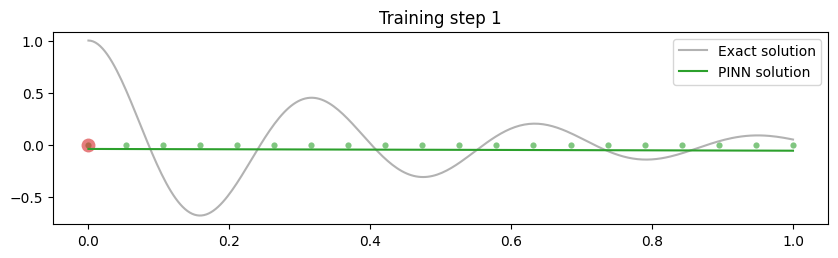

In [268]:
plt.figure(figsize=(10,2.5))
plt.scatter(physics_t_frict_coeff.detach().cpu()[0:physics_t_points, 0], 
            torch.zeros_like(physics_t_frict_coeff.cpu())[0:physics_t_points, 0], 
            s=20, 
            linewidth=0, 
            color="tab:green", 
            alpha=0.6)
plt.scatter(initial_t_frict_coeff.detach().cpu()[:, 0], 
            torch.zeros_like(initial_t_frict_coeff.cpu())[:, 0], 
            s=100, 
            linewidth=0, 
            color="tab:red", 
            alpha=0.6)
plt.plot(test_t_frict_coeff_total.cpu()[:,0], 
         u_exact.cpu(), 
         label="Exact solution", 
         color="tab:grey", 
         alpha=0.6)
plt.plot(test_t_frict_coeff_total.cpu()[:,0], 
         u_test.cpu(), 
         label="PINN solution", 
         color="tab:green")
plt.title(f"Training step {1}")
plt.legend()
plt.show()

### Loop:

In [269]:
print(f"Device tensor is stored on: {test_t_frict_coeff_total.device}")

Device tensor is stored on: cuda:0


loss: 1.1206086874008179 = 1.083358645439148 + 0.1 * 0.00016332736413460225 + 0.0001 * 372.3367004394531


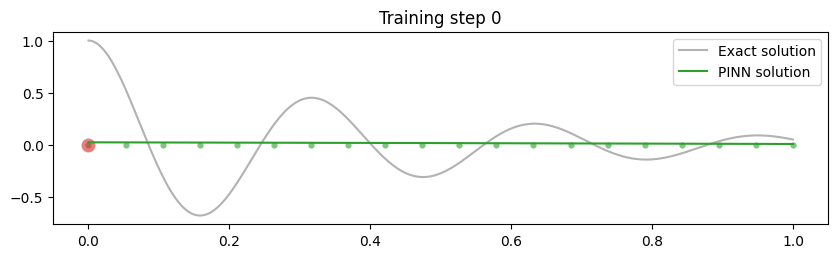

loss: 0.023180460557341576 = 0.0005886335857212543 + 0.1 * 0.014339896850287914 + 0.0001 * 211.578369140625


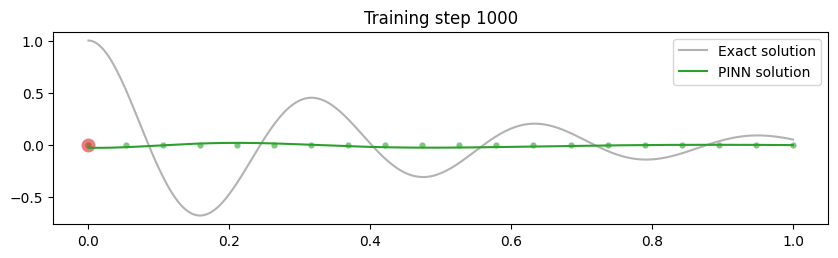

loss: 0.0022935536690056324 = 3.502164190649637e-06 + 0.1 * 0.000767333316616714 + 0.0001 * 22.133182525634766


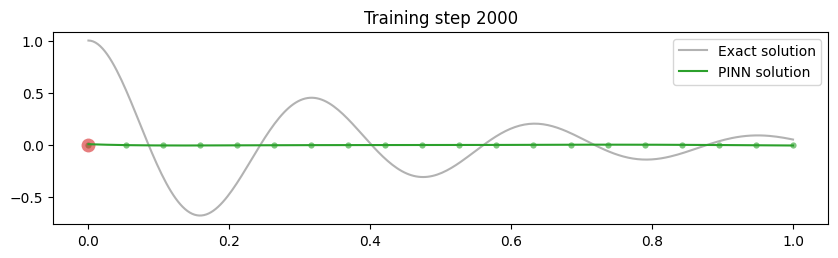

loss: 0.0007734887767583132 = 8.963548339124827e-07 + 0.1 * 1.5824595323010726e-07 + 0.0001 * 7.725766181945801


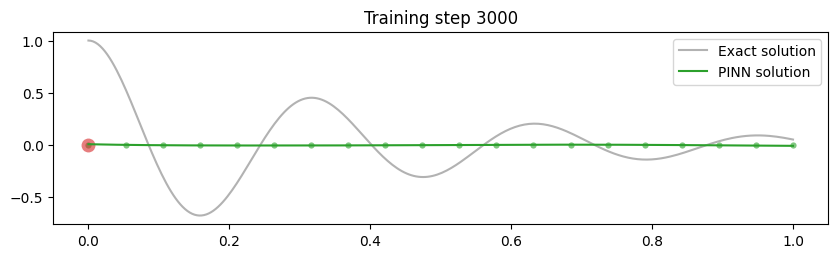

loss: 0.0003578375035431236 = 2.612941898405552e-07 + 0.1 * 2.661918188096024e-07 + 0.0001 * 3.575495958328247


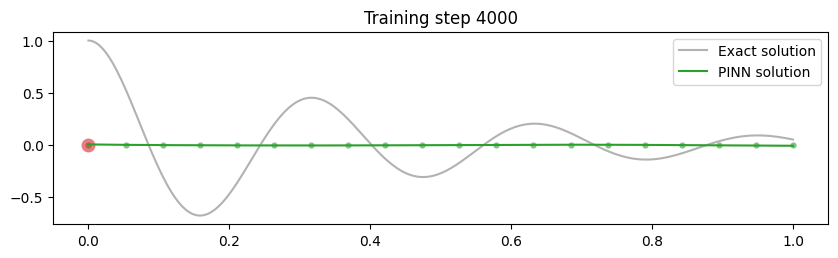

loss: 0.0013093252200633287 = 1.6816557035781443e-09 + 0.1 * 0.0056376028805971146 + 0.0001 * 7.455632209777832


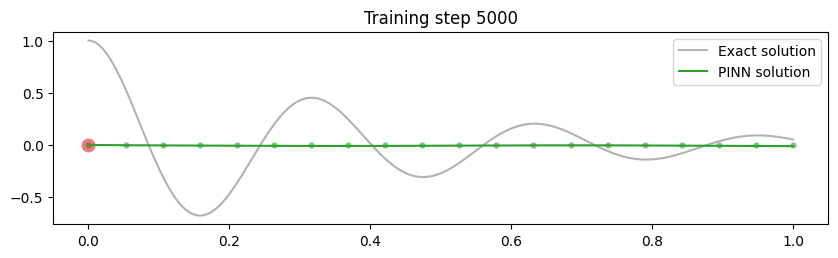

loss: 0.00013657179079018533 = 4.138403042475147e-08 + 0.1 * 4.341093244875083e-07 + 0.0001 * 1.3648699522018433


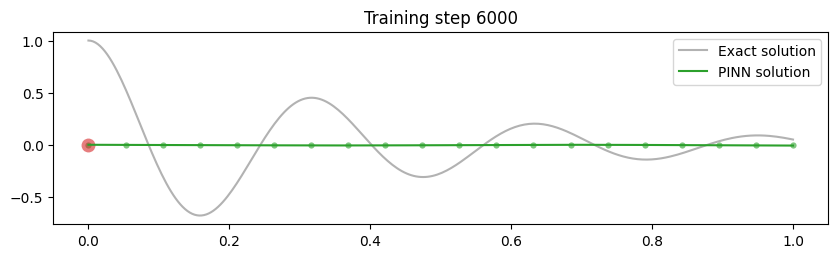

loss: 9.69336397247389e-05 = 2.763485795753695e-08 + 0.1 * 2.241456513729645e-06 + 0.0001 * 0.966818630695343


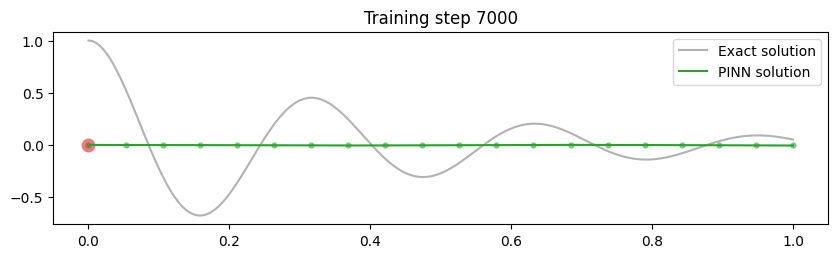

loss: 7.015980372671038e-05 = 4.552532573143253e-09 + 0.1 * 8.55445432534907e-06 + 0.0001 * 0.6929981112480164


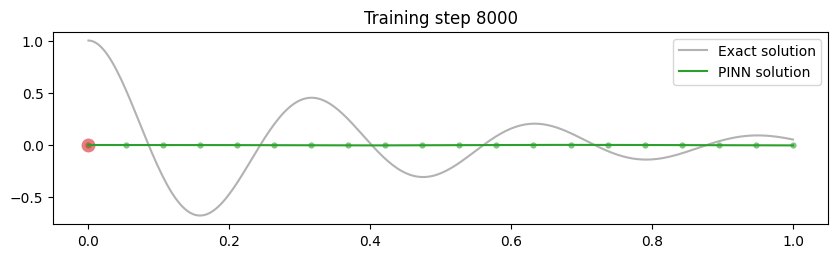

loss: 5.0127993745263666e-05 = 5.296531213616618e-09 + 0.1 * 6.1154423747211695e-09 + 0.0001 * 0.5012208819389343


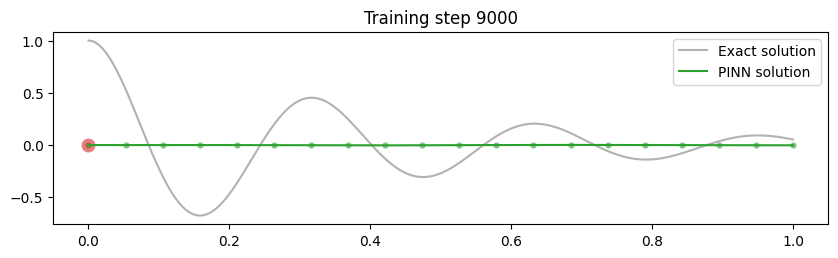

loss: 3.800848571700044e-05 = 2.689048983484099e-09 + 0.1 * 6.934443774753163e-08 + 0.0001 * 0.3799886405467987


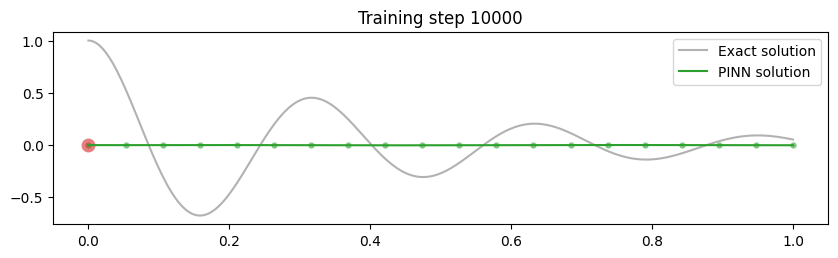

In [ ]:
# Starts for-loop with the number of epochs:
loss_history = []
for i in range(epochs):
    # clears old gradients from the last step (otherwise you’d just accumulate the gradients from all loss.backward() calls).
    optimiser.zero_grad()

    # FORWARD PASS computing initial loss using torch.autograd.grad which computes and returns the sum of gradients of outputs with respect to the inputs
    u_initial = pinn(initial_t_frict_coeff)
    loss_u_initial = (torch.squeeze(u_initial) - 1)**2

    du_dtdfrictcoeff_initial = torch.autograd.grad(outputs = u_initial, inputs = initial_t_frict_coeff, grad_outputs = torch.ones_like(u_initial), create_graph=True)[0]
        # grad: Computes and returns the sum of gradients of outputs with respect to the inputs.
            # Ref.:  https://pytorch.org/docs/stable/autograd.html#default-grad-layouts
    loss_dudt_initial = (torch.squeeze(du_dtdfrictcoeff_initial[:,0]) - 0)**2

    # FORWARD PASS computing physics loss
    u_physics = pinn(physics_t_frict_coeff)
    du_dtdfrictcoeff_physics = torch.autograd.grad(outputs = u_physics, inputs = physics_t_frict_coeff, grad_outputs = torch.ones_like(u_physics), create_graph=True)[0]
    d2u_d2tdfrictcoeff_physics = torch.autograd.grad(outputs = du_dtdfrictcoeff_physics, inputs = physics_t_frict_coeff, grad_outputs = torch.ones_like(du_dtdfrictcoeff_physics), create_graph=True)[0]
    loss_u_physics = torch.mean((d2u_d2tdfrictcoeff_physics[:,0].view(-1,1) + frict_coeff_total*(du_dtdfrictcoeff_physics[:,0].view(-1,1)) + spring_constant*u_physics)**2) #torch.mean((d2udt2_physics + mu*dudt_physics + k*u_physics)**2)

    # backpropagate joint loss (We use the model’s prediction and (the corresponding label) to calculate the error (loss)) 
    # loss = loss_initial_boundary + hyperparam_loss_initial*loss_initial + hyperparam_loss_physics*loss_physics
    loss = loss_u_initial + hyperparam_loss_initial*loss_dudt_initial + hyperparam_loss_physics*loss_u_physics
    loss_history.append(loss)
    # computes the gradients from each .grad_fn, accumulates them in the respective tensor’s .grad attribute using the chain rule, propagates all the way to the leaf tensors.
    # loss.backward():  
        # responsible for computing the gradients of the loss function with respect to the weights and biases of the neural network.
        # In other words, it calculates how much each weight and bias should be adjusted to minimize the loss function.
        # Ref. https://saturncloud.io/blog/pytorch-understanding-the-connection-between-lossbackward-and-optimizerstep/: 
    loss.backward() 
        # Computes the sum of gradients of given tensors with respect to graph leaves.
            # Ref.:  https://pytorch.org/docs/stable/autograd.html#default-grad-layouts

    # optimizer.step(): 
        # responsible for updating the weights and biases of the neural network based on the gradients. 
        # In other words, it adjusts the weights and biases in the direction that reduces the loss function the most.
        # Ref. https://saturncloud.io/blog/pytorch-understanding-the-connection-between-lossbackward-and-optimizerstep/: 
        # Performs a single optimization step (parameter update).
        # Ref: https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.step.html
    optimiser.step() 
    
    # plot the result as training progresses
    if i % 1000 == 0: 
        #print(u.abs().mean().item(), dudt.abs().mean().item(), d2udt2.abs().mean().item())
        print(f'loss: {loss} = {loss_u_initial} + {hyperparam_loss_initial} * {loss_dudt_initial} + {hyperparam_loss_physics} * {loss_u_physics}')
        u_test = pinn(test_t_frict_coeff_total).detach().cpu()
        plt.figure(figsize=(10,2.5))
        plt.scatter(physics_t_frict_coeff.detach().cpu()[0:physics_t_points, 0], 
                    torch.zeros_like(physics_t_frict_coeff.cpu())[0:physics_t_points, 0], 
                    s=20, 
                    linewidth=0, 
                    color="tab:green", 
                    alpha=0.6)
        plt.scatter(initial_t_frict_coeff.detach().cpu()[:, 0], 
                    torch.zeros_like(initial_t_frict_coeff.cpu())[:, 0], 
                    s=100, 
                    linewidth=0, 
                    color="tab:red", 
                    alpha=0.6)
        plt.plot(test_t_frict_coeff_total.cpu()[:,0], 
                 u_exact.cpu(), 
                 label="Exact solution", 
                 color="tab:grey", 
                 alpha=0.6)
        plt.plot(test_t_frict_coeff_total.cpu()[:,0], 
                 u_test.cpu()[:,0], 
                 label="PINN solution", 
                 color="tab:green")
        plt.title(f"Training step {i}")
        plt.legend()
        plt.show()



In [ ]:
u_test[:,0].size()

In [ ]:
u_exact.size()

In [ ]:
test_t_frict_coeff_total[:,0].size() 